# Import required libraries

This cell imports the required libraries for the project. The libraries cover various functionalities:

- **`os`**: For interacting with the file system.
- **`pprint`**: For formatted printing of data structures.
- **`numpy`**: For numerical operations, particularly array manipulations.
- **`pandas`**: For handling structured data in tabular form.
- **`matplotlib.pyplot`**: For visualizing data and results.
- **`glob`**: For pattern matching and retrieving file names.
- **`random`**: For random number generation, which might be used for data shuffling or sampling.
- **`PIL.Image`**: For handling image files.
- **`sklearn.model_selection.train_test_split`**: For splitting data into training and testing subsets.
- **`IPython.display`**: For enhanced notebook display functionalities, including clearing outputs.

The `%matplotlib inline` magic command ensures that plots are displayed inline in the notebook.

In [2]:
import os
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import random
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split

from IPython import display
from IPython.display import clear_output

%matplotlib inline

This cell installs additional libraries and dependencies required for the project. The commands include:

- **`tensorflow/examples`**: A repository containing TensorFlow example projects and tutorials.
- **`pydot`**: A Python interface to Graphviz, used for creating visual representations of graphs and diagrams.
- **`graphviz`**: A tool for rendering graphs described in DOT language.
- **`pydotplus`**: An enhanced interface to Graphviz, building upon `pydot`.

These installations are necessary for handling model visualizations, dependencies, and other specific functionalities in the project.

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install pydot
!pip install graphviz
!pip install pydotplus

This cell imports TensorFlow and additional modules required for the deep learning model, particularly for image segmentation tasks:

- **`tensorflow`**: The primary framework for building and training deep learning models.
- **`pix2pix`**: A model from TensorFlow's `examples` library, commonly used for image-to-image translation tasks, which can also support image segmentation.
- **`tensorflow.keras.layers`**: Includes layers such as:
  - `Conv2D`, `Conv2DTranspose`: For convolutional operations, used in encoder-decoder architectures.
  - `Dropout`: For regularization to prevent overfitting.
  - `MaxPooling2D`: For down-sampling spatial dimensions in the model.
  - `Concatenate`, `BatchNormalization`: For merging layers and normalizing activations.
- **`ResNet50`**: A pre-trained deep neural network, often used as a backbone for segmentation tasks.
- **`tensorflow.keras`**: The Keras API integrated into TensorFlow for model creation and layer management.

The cell also prints the version of TensorFlow being used, ensuring compatibility with the required libraries and models.

In [4]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix

from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Conv2DTranspose, Concatenate, BatchNormalization
from tensorflow.keras.applications import ResNet50

from tensorflow.keras import layers, models


print(tf.__version__) # Check the version of tensorflow used



2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This cell sets up the paths for the dataset and organizes the image and mask directories for the project. It performs the following steps:

- **`data_path`**: Specifies the root directory of the dataset stored in Google Drive.
- **`image_dir` and `mask_dir`**: Define subdirectories for images and corresponding ground truth masks.
- **`glob.glob`**: Retrieves all file paths matching a specific pattern:
  - **Images**: Files ending with `.jpg` in the `image_dir`.
  - **Masks**: Files ending with `.png` in the `mask_dir`.
- **`sort()`**: Ensures the lists of image and mask file paths are sorted, maintaining a consistent order between images and their corresponding masks.

This organization is critical for preparing the dataset for further processing and training.


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Aerial_Semantic_Segmentation/semantic_drone_dataset/training_set'

# Define directories for images and masks
image_dir = data_path + '/images'
mask_dir = data_path + '/gt/semantic/label_images'

# Get all image and mask files
all_image_path = glob.glob(f"{image_dir}/*.jpg")
all_mask_path = glob.glob(f"{mask_dir}/*.png")

all_image_path.sort()
all_mask_path.sort()

# Data Visualization

This cell visualizes a subset of images and their corresponding masks from the dataset to verify the alignment and quality of the data. It performs the following steps:

- **Dataset Statistics**:
  - Prints the total number of images and masks to ensure the dataset is loaded correctly.
- **Visualization**:
  - Randomly selects a specified number (`IM_SHOW_SIZE`) of images and their corresponding masks.
  - Opens the images and masks using `PIL.Image`.
  - Plots the images and masks side by side using `matplotlib.pyplot` for easy comparison.
- **Figure Layout**:
  - Configures the layout to display images and masks in a grid with titles indicating their filenames.


In [ ]:
IM_SHOW_SIZE = 10

# Print the number of images and masks
print(f"Total number of images: {len(all_image_path)}")
print(f"Total number of masks: {len(all_mask_path)}")
# Plot the images and masks side by side
plt.figure(figsize=(10, (IM_SHOW_SIZE / 2) * 6))
for i in range(0, IM_SHOW_SIZE):
    idx = random.randint(0, len(all_image_path) - 1)
    image_file = all_image_path[idx]
    mask_file = all_mask_path[idx]


    # Open image and corresponding mask
    image = Image.open(image_file)
    mask = Image.open(mask_file)

    # Plot the image
    ax = plt.subplot(10, 2, 2*i + 1)
    plt.imshow(image)
    plt.title(f"Image: {os.path.basename(image_file)}")


    # Plot the corresponding mask
    ax = plt.subplot(10, 2, 2*i + 2)
    plt.imshow(mask)
    plt.title(f"Mask: {os.path.basename(mask_file)}")


plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

# Create Mask from labled images

This cell converts the RGB-labeled segmentation masks into integer-labeled masks for machine learning model compatibility. It includes the following steps:

- **Load RGB-to-Object Mapping**:
  - Reads a CSV file (`class_dict.csv`) that maps RGB color values to object labels.
  - Creates a dictionary (`rgb_to_int_map`) for easy lookup of object labels by their RGB tuples.

- **Prepare Output Directory**:
  - Checks if the output directory exists for storing integer-labeled masks. If not, it creates the directory.

- **Process Masks**:
  - Iterates over all mask files, converts them from RGB to integer-labeled format, and saves them:
    - Loads each mask image using `PIL.Image`.
    - Converts the image to an RGB format if necessary.
    - Converts the image to a NumPy array for pixel-wise manipulation.
    - Initializes an empty array for storing integer labels corresponding to each pixel.
    - Maps RGB values in the mask to integer labels based on the `rgb_to_int_map` dictionary.
    - Saves the resulting integer-labeled array as a NumPy file (`.npy`) in the output directory.

This step ensures the masks are in a format suitable for training segmentation models.



In [ ]:
# Load the RGB to object number mapping from CSV
csv_file = data_path + '/gt/semantic/class_dict.csv'
rgb_to_object_df = pd.read_csv(csv_file)

# Create a dictionary to map RGB tuples to object numbers
rgb_to_int_map = {}
for index, row in rgb_to_object_df.iterrows():
    rgb_color = (row[' r'], row[' g'], row[' b'])
    rgb_to_int_map[rgb_color] = index  # Assign index as the object label

output_dir = data_path + '/gt/semantic/label_images_obj'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    # Load the image
    for mask_path in all_mask_path[312:]:
        image = Image.open(mask_path)

        # Convert the image to RGB (if it's not in RGB format)
        image_rgb = image.convert('RGB')

        # Convert the image to a numpy array
        image_rgb_np = np.array(image_rgb)

        # Create an empty array to store the integer labels
        height, width, _ = image_rgb_np.shape
        label_image = np.zeros((height, width), dtype=np.int32)

        # Replace RGB values with the corresponding integers from the dictionary

        for rgb_color, label in rgb_to_int_map.items():
            # Convert the tuple to a numpy array to allow comparison with the image
            rgb_color_array = np.array(rgb_color, dtype=np.uint8)

            # Create a mask where the RGB values match the current rgb_color
            mask = np.all(image_rgb_np == rgb_color_array, axis=-1)

            # Assign the corresponding label (index) to the mask in the label_image
            label_image[mask] = label

        output_path = os.path.join(output_dir, os.path.basename(mask_path).replace('.png', '_label.npy'))
        np.save(output_path, label_image)

## Read the stored mask lables

This cell sets up the directory path for the stored integer-labeled masks and retrieves the list of all mask files. It includes the following steps:

- **Directory Path**:
  - Defines `mask_lab_dir` as the directory where the integer-labeled masks are stored.

- **Retrieve Mask Files**:
  - Uses `glob.glob` to gather all `.npy` files in the directory, representing the stored integer-labeled masks.

- **Sort File List**:
  - Ensures the mask file paths are sorted to maintain a consistent order for subsequent processing.

This step prepares the dataset for efficient loading and use in the training or evaluation pipeline.


In [ ]:
data_path = '/content/drive/MyDrive/Colab Notebooks/Aerial_Semantic_Segmentation/semantic_drone_dataset/training_set'

# Define directories for mask lables
mask_lab_dir = data_path + '/gt/semantic/label_images_obj'

# Get all image and mask lables files
all_mask_lab_path = glob.glob(f"{mask_lab_dir}/*.npy")

all_mask_lab_path.sort()

This cell visualizes a subset of segmentation masks and their corresponding integer-labeled masks to ensure the generated labels align correctly with the original masks. It performs the following steps:

- **Dataset Statistics**:
  - Prints the total number of original masks and integer-labeled masks to verify dataset completeness.

- **Visualization**:
  - Randomly selects a specified number (`IM_SHOW_SIZE`) of masks and their corresponding labels.
  - Opens the original masks using `PIL.Image` and the integer-labeled masks using `numpy.load`.
  - Plots the masks and labels side by side for easy comparison.

- **Figure Layout**:
  - Configures a grid layout for the visualizations and adds titles to indicate the filenames of each mask and label.

This step provides a qualitative evaluation of the mask-to-label conversion process.


Total number of masks: 400
Total number of masks lables: 100


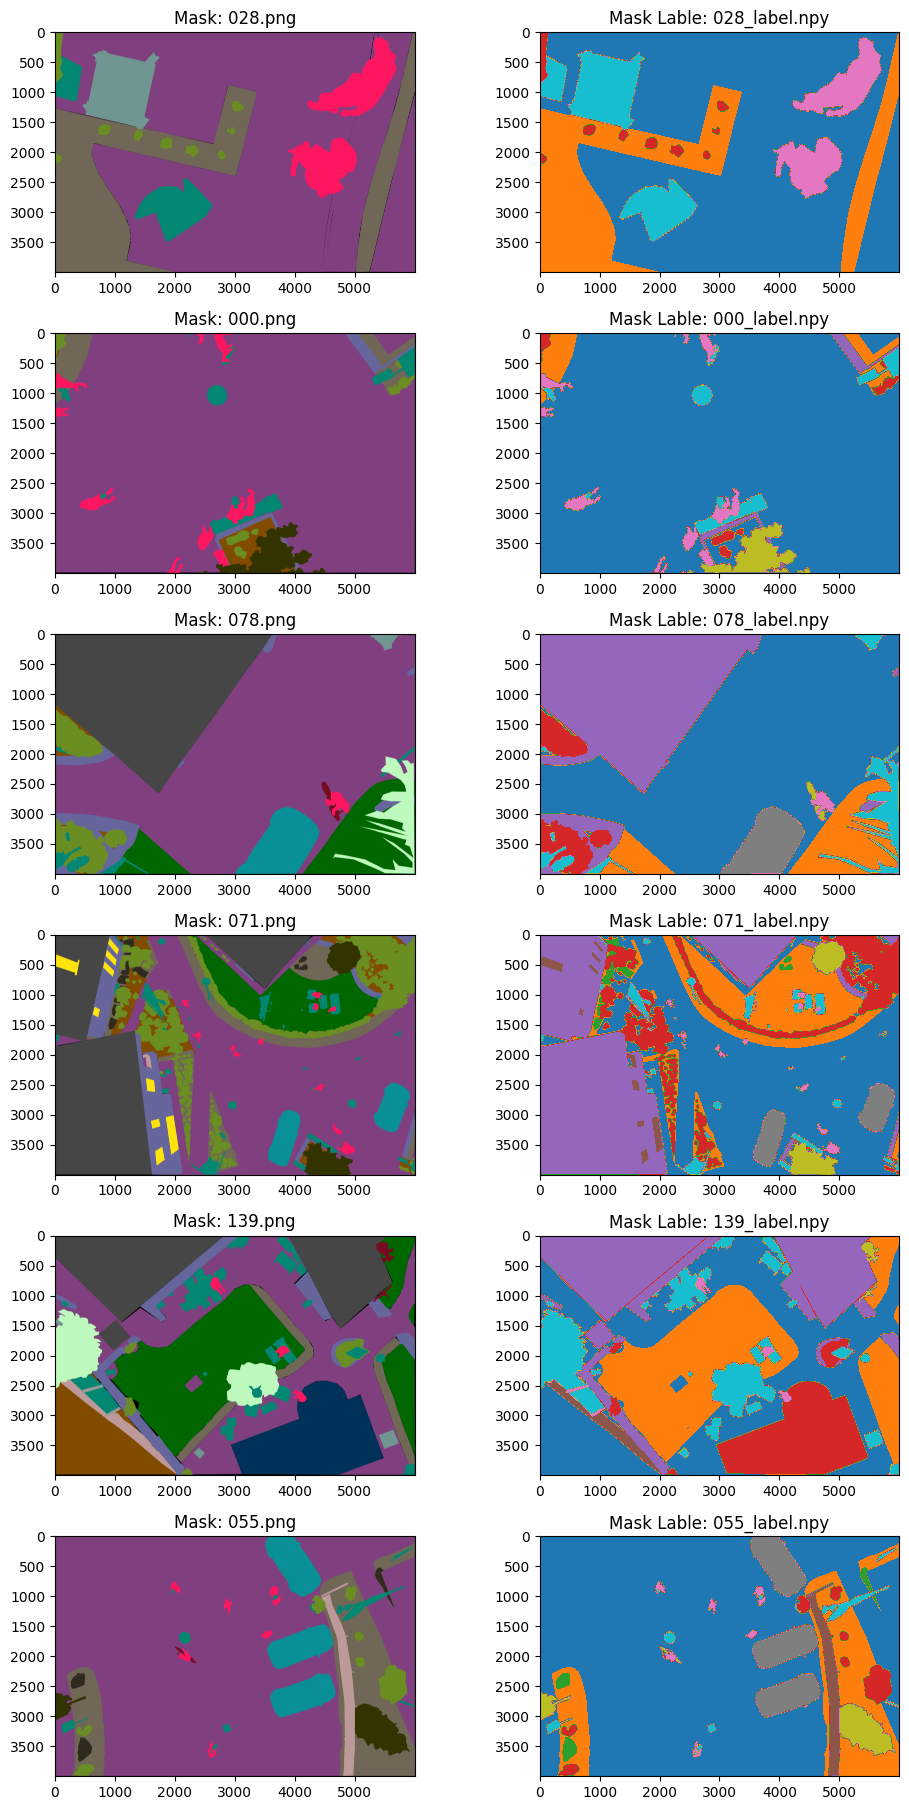

In [ ]:
IM_SHOW_SIZE = 6

# Print the number of Masks and lable masks
print(f"Total number of masks: {len(all_mask_path)}")
print(f"Total number of masks lables: {len(all_mask_lab_path)}")

# Plot the Masks and mask lables side by side
plt.figure(figsize=(10, (IM_SHOW_SIZE / 2) * 10))
for i in range(0, IM_SHOW_SIZE):
    idx = random.randint(0, len(all_mask_lab_path) - 1)
    mask_file = all_mask_path[idx]
    mask_lable_file = all_mask_lab_path[idx]


    # Open mask and corresponding mask lables
    mask = Image.open(mask_file)
    mask_lable = np.load(mask_lable_file)

    # Plot the mask
    ax = plt.subplot(10, 2, 2*i + 1)
    plt.imshow(mask)
    plt.title(f"Mask: {os.path.basename(mask_file)}")


    # Plot the corresponding mask lables
    ax = plt.subplot(10, 2, 2*i + 2)
    plt.imshow(mask_lable, cmap='tab10')
    plt.title(f"Mask Lable: {os.path.basename(mask_lable_file)}")


plt.tight_layout()
plt.show()


## Create Training / Validation / Testset

This cell splits the dataset into training, validation, and test sets. The steps include:

- **Dataset Splitting**:
  - First, the dataset is split into a development set (`devset_image_path` and `devset_mask_path`) and a test set (`testset_image_path` and `testset_mask_path`) using an 80-20 split with a random seed (`random_state=42`) for reproducibility.
  - Then, the development set is further split into training and validation sets using the same 80-20 ratio.

- **Dataset Statistics**:
  - Prints the number of images in the training, validation, and test sets to verify the splits.

This step ensures the dataset is divided into subsets for training the model, tuning its hyperparameters, and evaluating its performance on unseen data.


In [ ]:
devset_image_path, testset_image_path, devset_mask_path, testset_mask_path  = train_test_split(
    all_image_path, all_mask_lab_path, test_size=0.2, random_state=42)

trainset_image_path , val_image_path , trainset_mask_path, val_mask_path   = train_test_split(
    devset_image_path, devset_mask_path, test_size=0.2, random_state=42)

print(f"Number of training images: {len(trainset_image_path)}")
print(f"Number of validation images: {len(val_image_path)}")
print(f"Number of test images: {len(testset_image_path)}")

Number of training images: 256
Number of validation images: 64
Number of test images: 80


# Create Tensorflow Dataset

This cell defines utility functions for processing and creating TensorFlow datasets from the image and mask files. The steps include:

- **`extract_patches`**:
  - Splits an image and its corresponding mask into smaller patches of a specified size (`patch_size`).
  - Uses TensorFlow's `extract_patches` method to create patches efficiently.
  - Returns the patches as tensors for both images and masks.

- **`load_mask_numpy`**:
  - Loads a mask from a NumPy file (`.npy`) using `numpy.load`.
  - This function is wrapped with TensorFlow's `tf.py_function` to integrate seamlessly into the TensorFlow pipeline.

- **`load_and_preprocess`**:
  - Reads an image from its file path, decodes it into a tensor, and normalizes pixel values.
  - Loads and preprocesses the corresponding mask using `load_mask_numpy`.
  - Extracts patches from the image and mask using the `extract_patches` function.

- **`create_dataset`**:
  - Creates a TensorFlow dataset from the list of image and mask file paths.
  - Maps the `load_and_preprocess` function to each pair of image and mask paths for preprocessing.
  - Flattens the dataset into individual patches, where each entry corresponds to a pair of an image patch and a mask patch.

These functions are essential for preparing the dataset in a format suitable for training deep learning models.


In [ ]:
def extract_patches(image, mask, patch_size=128):
    """
    Extracts patches from images and corresponding masks.
    Args:
        image: A tensor representing the input RGB image.
        mask: A tensor representing the segmentation mask (single channel).
        patch_size: The size of the patches (default: 128x128).
    Returns:
        A tuple of (image_patches, mask_patches).
    """
    # Convert images and masks to 4D tensors (add batch dimension)
    image = tf.expand_dims(image, axis=0)
    mask = tf.expand_dims(mask, axis=0)

    # Extract patches from the images
    image_patches = tf.image.extract_patches(
        images=image,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'  # or 'SAME' depending on desired behavior
    )

    # Extract patches from the masks
    mask_patches = tf.image.extract_patches(
        images=mask,
        sizes=[1, patch_size, patch_size, 1],
        strides=[1, patch_size, patch_size, 1],
        rates=[1, 1, 1, 1],
        padding='VALID'  # or 'SAME' depending on desired behavior
    )

    # Remove the batch dimension from the patches
    image_patches = tf.squeeze(image_patches, axis=0)
    mask_patches = tf.squeeze(mask_patches, axis=0)

    # Reshape the image patches to have the shape: (num_patches, patch_size, patch_size, 3)
    image_patches = tf.reshape(image_patches, [-1, patch_size, patch_size, 3])  # RGB images

    # Reshape the mask patches to have the shape: (num_patches, patch_size, patch_size, 1)
    mask_patches = tf.reshape(mask_patches, [-1, patch_size, patch_size, 1])  # Single-channel masks

    return image_patches, mask_patches

def load_mask_numpy(mask_path_str):
    # Convert the tensor to a numpy-compatible string
    mask_path_str = mask_path_str.numpy().decode("utf-8")
    # Load the mask from the NumPy file
    mask = np.load(mask_path_str)
    return mask

def load_and_preprocess(image_path, mask_path, patch_size=128):
    """
    Loads and preprocesses an image and its corresponding mask.
    """
    # Load the image file
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)

    # # Cast image to float32 and normalize pixel values to [0, 1]
    # image = tf.image.convert_image_dtype(image, dtype=tf.float32)

    # Use tf.py_function to load mask using numpy
    mask = tf.py_function(func=load_mask_numpy, inp=[mask_path], Tout=tf.float32)
    mask = tf.expand_dims(mask, axis=-1)  # Add channel dimension if necessary

    # Cast the mask to integer
    mask = tf.cast(mask, tf.int32)

    # Extract patches from both image and mask
    image_patches, mask_patches = extract_patches(image, mask, patch_size)

    return image_patches, mask_patches

def create_dataset(image_paths, masks, patch_size=128):
    """
    Create a TensorFlow dataset from image paths and corresponding masks.
    """
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, masks))

    # Apply the load_and_preprocess function
    dataset = dataset.map(lambda img_path, mask: load_and_preprocess(img_path, mask, patch_size),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Flatten the patches so each entry is a pair of (image_patch, mask_patch)
    dataset = dataset.flat_map(lambda image_patches, mask_patches: tf.data.Dataset.from_tensor_slices((image_patches, mask_patches)))

    return dataset

This cell creates TensorFlow datasets for the training and validation subsets using the utility functions defined earlier. The steps include:

- **`create_dataset`**:
  - The function is applied to the training and validation image and mask paths.
  - The specified patch size (`128x128`) is used to divide images and masks into smaller patches.

- **Generated Datasets**:
  - `train_ds`: Contains preprocessed image and mask patches for training the model.
  - `val_ds`: Contains preprocessed image and mask patches for validating the model during training.

These datasets are ready to be used as inputs for the deep learning model.



In [ ]:
# Create the dataset
train_ds = create_dataset(trainset_image_path, trainset_mask_path, patch_size=128)
val_ds = create_dataset(val_image_path, val_mask_path, patch_size=128)

This cell inspects the TensorFlow training dataset (`train_ds`) by checking the data type and shape of the image and mask patches. The steps include:

- **Dataset Iteration**:
  - Iterates over the `train_ds` dataset to extract a batch of image and mask patches.

- **Printing Metadata**:
  - Prints the data type and shape of the image patches:
    - `dtype`: Ensures the image patches are in the expected data type (e.g., `uint8` for RGB images).
    - `shape`: Confirms the patches are of the correct size (e.g., `128x128x3` for RGB images).
  - Prints the data type and shape of the mask patches:
    - `dtype`: Validates the mask patches have the correct integer type (`int32`) for class labels.
    - `shape`: Confirms the patches are in the expected size (e.g., `128x128x1` for single-channel masks).

This step verifies that the datasets are prepared correctly and meet the input requirements for the deep learning model.


In [ ]:
for image_patches, mask_patches in train_ds:
        print("Image patches dtype:", image_patches.dtype)
        print("Image patches shape:", image_patches.shape)

        print("Mask patches dtype:", mask_patches.dtype)
        print("Mask patches shape:", mask_patches.shape)
        break

Image patches dtype: <dtype: 'uint8'>
Image patches shape: (128, 128, 3)
Mask patches dtype: <dtype: 'int32'>
Mask patches shape: (128, 128, 1)


This cell defines a custom TensorFlow layer for data augmentation, aimed at improving the model's robustness by introducing random transformations to the training data. The details include:

- **Class Definition**:
  - `Augment`: A subclass of `tf.keras.layers.Layer` for implementing custom augmentation logic.

- **Random Flip**:
  - `RandomFlip`: Applies random horizontal flips to both the input images and their corresponding labels.
  - Ensures that both images and masks are augmented identically to maintain alignment.

- **Seed for Reproducibility**:
  - A seed value is used to ensure that the random transformations are reproducible across training sessions.

- **`call` Method**:
  - The `call` method applies the augmentation transformations to the input images and labels and returns the augmented data.

This augmentation layer enhances the training dataset by introducing variability, helping the model generalize better to unseen data.


In [ ]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

This cell sets up key hyperparameters for training the model:

- **`TRAIN_LENGTH`**:
  - Represents the total number of training images in the dataset.

- **`BATCH_SIZE`**:
  - Defines the number of samples processed together in a single forward and backward pass during training. A batch size of 64 is used.

- **`BUFFER_SIZE`**:
  - Sets the buffer size for shuffling the dataset. A large buffer ensures better shuffling, helping the model learn more effectively.

These parameters are critical for controlling the efficiency and performance of the training process.


In [ ]:
TRAIN_LENGTH = len(trainset_image_path)
BATCH_SIZE = 64
BUFFER_SIZE = 1000


This cell prepares the training and validation datasets as batches optimized for model training:

- **Training Dataset (`train_batches`)**:
  - **`cache`**: Caches the dataset in memory to improve performance.
  - **`shuffle`**: Randomly shuffles the dataset using the `BUFFER_SIZE` defined earlier.
  - **`batch`**: Groups the dataset into batches of size `BATCH_SIZE`.
  - **`repeat`**: Repeats the dataset indefinitely, ensuring that batches are continuously available during training.
  - **`map(Augment())`**: Applies the custom data augmentation defined earlier to introduce variability in the training data.
  - **`prefetch`**: Prefetches batches asynchronously to improve data pipeline efficiency using `tf.data.AUTOTUNE`.

- **Validation Dataset (`val_batches`)**:
  - Only batches the dataset using the `BATCH_SIZE`, as no augmentation or shuffling is needed for validation.

These steps prepare the datasets for efficient feeding into the model during training and validation.


In [ ]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)


This cell defines a utility function for visualizing the input image, ground truth mask, and predicted mask side by side:

- **Function `display`**:
  - Takes a list of images (`display_list`) as input.
  - Uses `matplotlib` to create a figure and plot the images in a row.

- **Titles**:
  - Assigns descriptive titles to the images in the row: "Input Image," "True Mask," and "Predicted Mask."

- **Visualization**:
  - Converts each tensor into an image format using `tf.keras.utils.array_to_img`.
  - Disables axes for a cleaner visualization.

This function is useful for qualitative evaluation of the model's predictions against the ground truth.


In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

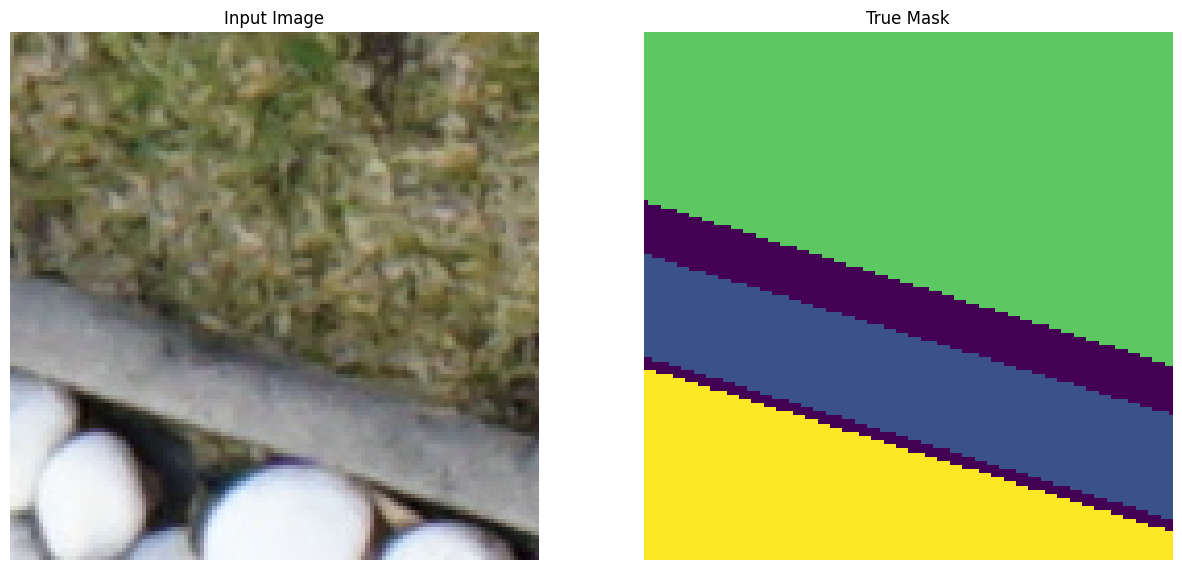

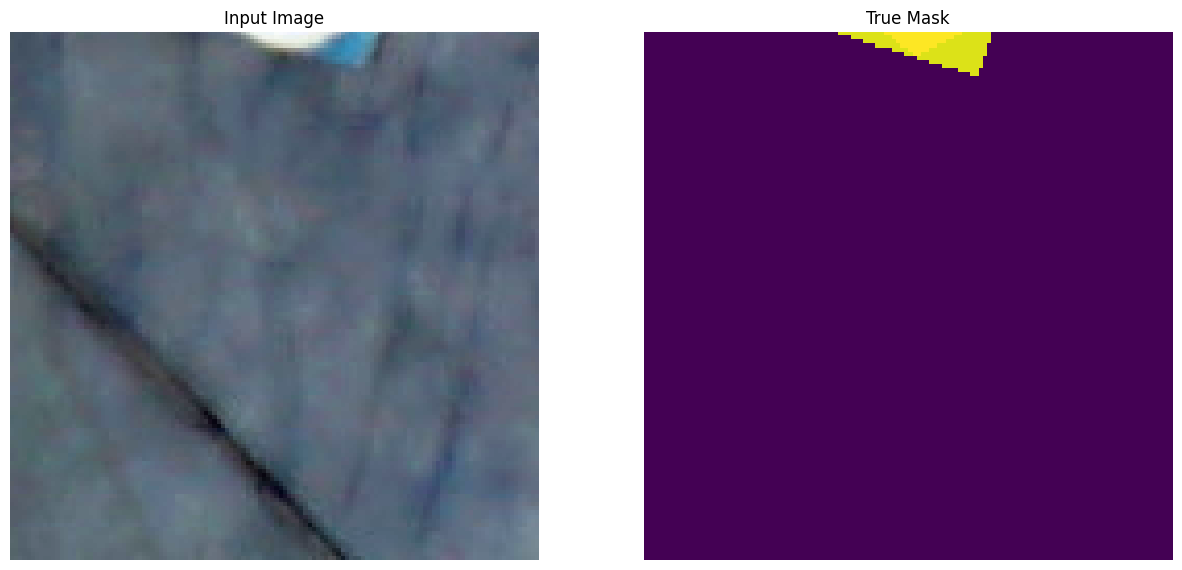

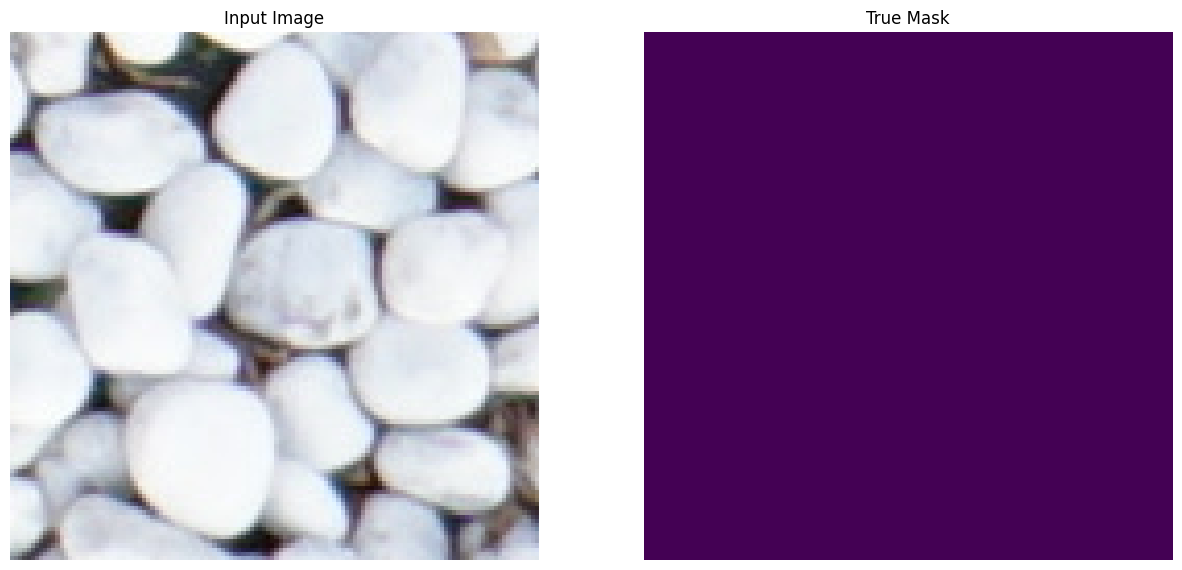

In [ ]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

# MobileNetV2 model

This cell initializes the MobileNetV2 model as the backbone for the segmentation task and extracts features at multiple scales. The steps include:

- **MobileNetV2 Initialization**:
  - `tf.keras.applications.MobileNetV2`: A pre-trained MobileNetV2 model is loaded with input size `[128, 128, 3]` and without the classification head (`include_top=False`).

- **Feature Extraction Layers**:
  - Specifies key layers from MobileNetV2 (`layer_names`) to extract features at different spatial resolutions, such as:
    - `block_1_expand_relu` (64x64)
    - `block_3_expand_relu` (32x32)
    - `block_6_expand_relu` (16x16)
    - `block_13_expand_relu` (8x8)
    - `block_16_project` (4x4)

- **Feature Extraction Model**:
  - Creates a new model (`down_stack`) with the same input as MobileNetV2 but outputs the activations of the specified layers.
  - Sets the `down_stack` model to non-trainable (`trainable=False`) to freeze its weights during training.

This feature extraction model serves as the encoder in the segmentation architecture, capturing multi-scale spatial features from the input images.


In [5]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


This cell defines the decoder or upsampling stack for the segmentation model, responsible for reconstructing the spatial resolution of the output to match the input image size. The steps include:

- **`pix2pix.upsample`**:
  - A utility function that performs transposed convolution to increase the spatial resolution.
  - The parameters specify the number of filters (e.g., 512, 256) and kernel size (3x3).

- **Upsampling Layers**:
  - The upsampling stack progressively increases the resolution from:
    - `4x4` → `8x8` with 512 filters
    - `8x8` → `16x16` with 256 filters
    - `16x16` → `32x32` with 128 filters
    - `32x32` → `64x64` with 64 filters

These layers work in conjunction with the encoder to form a U-Net-like architecture for image segmentation.


In [6]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

This cell defines the U-Net-like segmentation model architecture. The steps include:

- **Custom Layer for Type Casting**:
  - `CastToFloat32`: A custom TensorFlow layer that casts the input tensor to `float32` to ensure compatibility with subsequent layers.

- **`unet_model` Function**:
  - **Inputs**:
    - Defines the input layer with a shape of `[128, 128, 3]` for RGB images.
    - Casts the input to `float32` and normalizes pixel values to the range `[0, 1]` using `tf.keras.layers.Rescaling`.
  - **Downsampling**:
    - Passes the input through the encoder (`down_stack`) to extract multi-scale features.
    - Stores the outputs of intermediate layers in `skips` for use in skip connections.
  - **Upsampling**:
    - Iterates through the upsampling layers (`up_stack`) and corresponding `skips`.
    - Combines the upsampled features with the corresponding skip connections using `tf.keras.layers.Concatenate`.
  - **Final Layer**:
    - Adds a transposed convolution layer (`Conv2DTranspose`) as the output layer to generate the final segmentation map. The `output_channels` parameter specifies the number of classes for segmentation.

- **Model Return**:
  - Returns the U-Net model, combining the encoder (`down_stack`), decoder (`up_stack`), and skip connections.

This architecture is well-suited for image segmentation tasks, effectively capturing spatial details and context.


In [7]:
# Custom layer for type casting
class CastToFloat32(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.cast(inputs, tf.float32)


def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])

  # Use custom layer to convert to float32
  x = CastToFloat32()(inputs)
  # Normalize input images to the range [0, 1]
  x = tf.keras.layers.Rescaling(1./255)(x)

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

## Train the model

This cell initializes and compiles the U-Net model for training. The steps include:

- **Output Classes**:
  - `OUTPUT_CLASSES = 25`: Specifies the number of output classes for segmentation, which corresponds to the number of distinct labels in the dataset.

- **Model Initialization**:
  - Calls the `unet_model` function with `OUTPUT_CLASSES` to define the segmentation model.

- **Model Compilation**:
  - **Optimizer**:
    - Uses the Adam optimizer, which is efficient for training deep learning models.
  - **Loss Function**:
    - `SparseCategoricalCrossentropy`: Calculates the loss for multi-class classification tasks. The `from_logits=True` argument indicates that the model's output is unscaled logits.
  - **Metrics**:
    - Tracks `accuracy` during training and validation to monitor the model's performance.

This step prepares the model for the training process.


In [8]:
OUTPUT_CLASSES = 25

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

This cell visualizes the architecture of the U-Net model using TensorFlow's `plot_model` utility. The steps include:

- **`plot_model`**:
  - Displays the structure of the model, including its layers and connections.
  - **Arguments**:
    - `show_shapes=True`: Includes the shapes of the input and output tensors for each layer.
    - `expand_nested=True`: Expands nested layers for better visualization.
    - `dpi=64`: Adjusts the resolution of the plot.

This visualization provides a clear overview of the U-Net architecture, helping to understand the flow of data through the model.


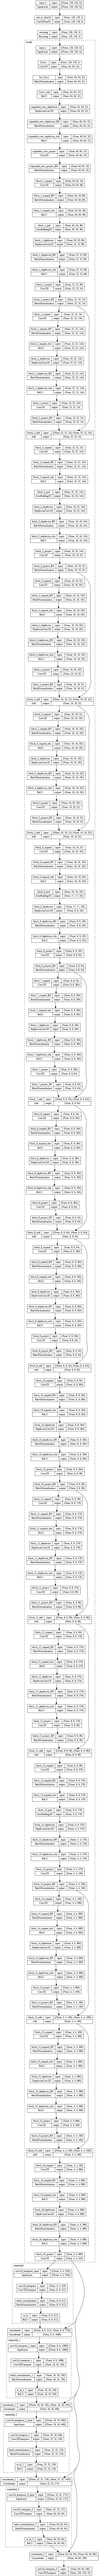

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, expand_nested=True, dpi=64)

This cell defines a utility function for creating segmentation masks from the model's predictions. The steps include:

- **Function `create_mask`**:
  - **`tf.math.argmax`**:
    - Extracts the class with the highest predicted probability for each pixel along the last axis (`axis=-1`).
  - **Expand Dimensions**:
    - Adds a new axis to match the shape of the original mask using `tf.newaxis`.
  - **Batch Handling**:
    - Returns only the first mask in the batch (`pred_mask[0]`), assuming predictions are made on a single batch.

This function processes the raw model outputs into a format suitable for visualization or further analysis.


In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

This cell defines a utility function for visualizing model predictions alongside the input image and ground truth mask. The steps include:

- **Function `show_predictions`**:
  - **Parameters**:
    - `dataset`: An optional TensorFlow dataset. If provided, predictions are displayed for samples from the dataset.
    - `num`: The number of samples to display from the dataset (default is 1).
  - **Visualization Workflow**:
    - If a `dataset` is provided:
      - Iterates through the specified number of samples (`num`) in the dataset.
      - For each sample, predicts the mask using the model (`model.predict`) and visualizes the input image, ground truth mask, and predicted mask using the `display` function.
    - If no `dataset` is provided:
      - Displays predictions for the predefined `sample_image` and `sample_mask`.

This function allows qualitative assessment of the model's performance on sample data.


In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

This cell defines a custom Keras callback to display model predictions during training. The steps include:

- **Class `DisplayCallback`**:
  - Subclasses `tf.keras.callbacks.Callback` to implement custom behavior at specific stages of training.

- **`on_epoch_end` Method**:
  - Triggered at the end of each training epoch.
  - **Clear Output**:
    - Clears the notebook output using `clear_output(wait=True)` to keep the display clean and updated.
  - **Show Predictions**:
    - Calls the `show_predictions` function to display the model's predictions on sample data.
  - **Print Statement**:
    - Logs the epoch number to indicate progress in training.

This callback provides real-time visual feedback on the model's performance, helping to monitor improvements across epochs.


In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

This cell trains the segmentation model using the prepared training and validation datasets. The steps include:

- **Hyperparameters**:
  - `EPOCHS`: The number of training epochs, set to 30.
  - `VALIDATION_STEPS`: The number of steps to run during validation, calculated as the length of the validation dataset divided by the batch size.
  - `STEPS_PER_EPOCH`: The number of steps in each training epoch, calculated as the length of the training dataset divided by the batch size.

- **Training Process**:
  - Calls `model.fit` to train the model.
  - **Arguments**:
    - `train_batches`: The training dataset.
    - `epochs`: The total number of epochs to train.
    - `steps_per_epoch`: The number of steps in each epoch.
    - `validation_steps`: The number of validation steps in each epoch.
    - `val_batches`: The validation dataset.
    - `callbacks`: Includes `DisplayCallback` to visualize predictions after each epoch.

- **Training Metrics**:
  - Monitors `loss` and `accuracy` on the training and validation datasets during each epoch.

This cell executes the core training process, with real-time feedback provided by the custom callback for predictions.


1/1 [==============================] - 0s 45ms/step


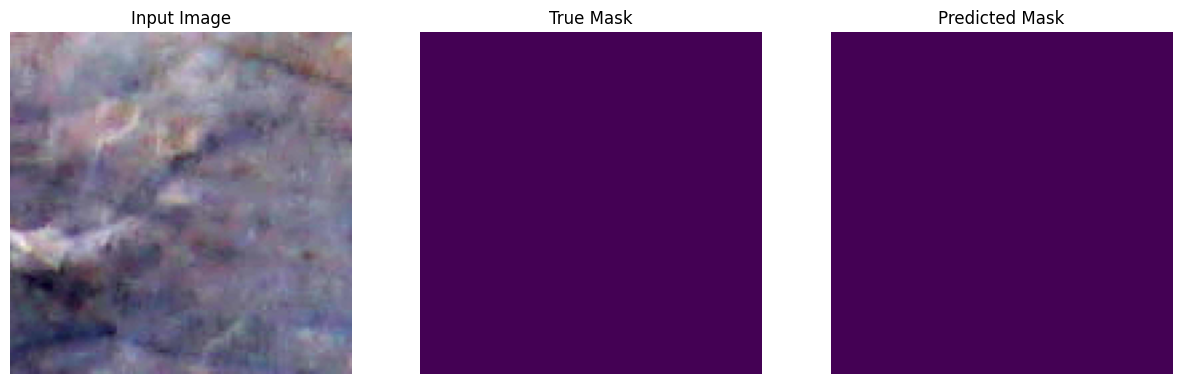


Sample Prediction after epoch 30

4/4 [==============================] - 15s 5s/step - loss: 0.4085 - accuracy: 0.8887 - val_loss: 3.7715 - val_accuracy: 0.2199


In [ ]:
EPOCHS = 30
VALIDATION_STEPS = len(val_image_path) // BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

This cell visualizes the training and validation metrics over the epochs to evaluate the model's performance during training. The steps include:

- **Extract Metrics**:
  - Retrieves training and validation accuracy (`accuracy` and `val_accuracy`) and loss (`loss` and `val_loss`) from the model history object.

- **Plot Configuration**:
  - **Subplot 1**: Plots training and validation accuracy over the epochs, displaying trends to assess how well the model learns.
  - **Subplot 2**: Plots training and validation loss, highlighting overfitting or underfitting trends.

- **Titles and Legends**:
  - Adds titles and legends to differentiate between training and validation metrics.

This visualization helps in diagnosing model performance and identifying potential issues like overfitting or insufficient training.


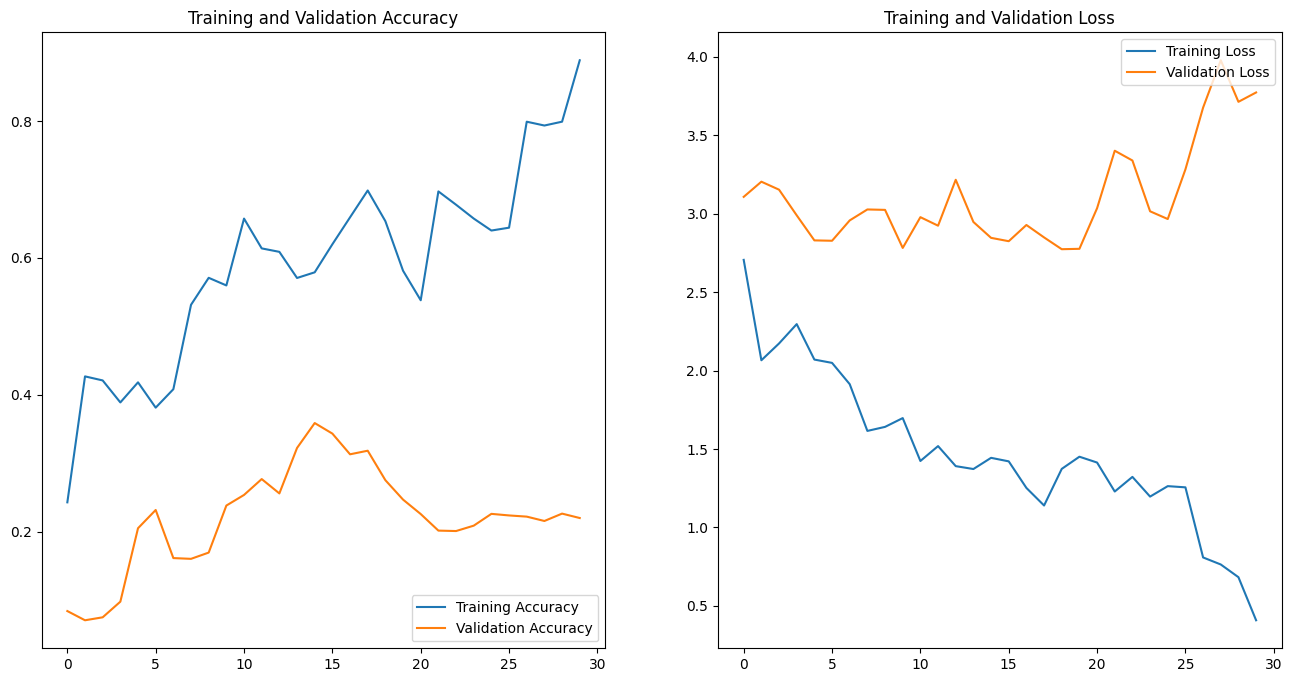

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# ResNet50 Model

This cell defines an improved U-Net architecture using ResNet50 as the encoder backbone for feature extraction. The details include:

- **Function `improved_unet`**:
  - **Parameters**:
    - `input_shape`: The input image dimensions, defaulting to `(256, 256, 3)`.
    - `num_classes`: The number of output segmentation classes, defaulting to 255.

- **Encoder**:
  - **Base Model**:
    - Uses ResNet50 pre-trained on ImageNet (`weights='imagenet'`) as the backbone.
    - Disables training for ResNet50 (`trainable=False`) to preserve the pre-trained weights.
  - **Skip Connections**:
    - Extracts features from specific ResNet50 layers (`conv1_conv`, `conv2_block3_out`, etc.) for use in the decoder.

- **Decoder**:
  - **Transposed Convolution Layers**:
    - Performs upsampling to increase spatial resolution.
    - Merges skip connections from the encoder to retain spatial details.
  - **Additional Layers**:
    - Adds `Dropout` for regularization and `BatchNormalization` for stable training.

- **Output Layer**:
  - **Final Upsampling**:
    - Ensures the output matches the input image resolution.
  - **Segmentation Map**:
    - Uses a `Conv2D` layer with a softmax activation to generate the final segmentation map.

- **Return**:
  - Returns the constructed U-Net model.

This architecture leverages the strength of ResNet50 for robust feature extraction, combined with U-Net's decoder for precise segmentation.


In [ ]:
def improved_unet(input_shape=(256, 256, 3), num_classes=255):
    inputs = Input(input_shape)

    # Encoder (Using ResNet50 as backbone)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)
    base_model.trainable = False
    skip_connections = [
        base_model.get_layer("conv1_conv").output,
        base_model.get_layer("conv2_block3_out").output,
        base_model.get_layer("conv3_block4_out").output,
        base_model.get_layer("conv4_block6_out").output,
    ]
    encoder_output = base_model.get_layer("conv5_block3_out").output

    # Decoder
    x = encoder_output
    for i, skip in enumerate(reversed(skip_connections)):
        x = Conv2DTranspose(512 // (2**i), (3, 3), strides=(2, 2), padding="same")(x)
        x = Concatenate()([x, skip])
        x = Dropout(0.5)(x)
        x = Conv2D(512 // (2**i), (3, 3), activation="relu", padding="same")(x)
        x = BatchNormalization()(x)

    # Ensure the final layer upsamples to 256x256
    x = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding="same")(x)  # Extra upsampling layer
    outputs = Conv2D(num_classes, (1, 1), activation="softmax")(x)

    model = tf.keras.Model(inputs, outputs)
    return model

In [ ]:
train_ds = create_dataset(trainset_image_path, trainset_mask_path, patch_size=256)
val_ds = create_dataset(val_image_path, val_mask_path, patch_size=256)

In [ ]:
for image_patches, mask_patches in train_ds:
        print("Image patches dtype:", image_patches.dtype)
        print("Image patches shape:", image_patches.shape)

        print("Mask patches dtype:", mask_patches.dtype)
        print("Mask patches shape:", mask_patches.shape)
        break

Image patches dtype: <dtype: 'uint8'>
Image patches shape: (256, 256, 3)
Mask patches dtype: <dtype: 'int32'>
Mask patches shape: (256, 256, 1)


In [ ]:
TRAIN_LENGTH = len(trainset_image_path)
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [ ]:
train_batches = (
    train_ds
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_ds.batch(BATCH_SIZE)

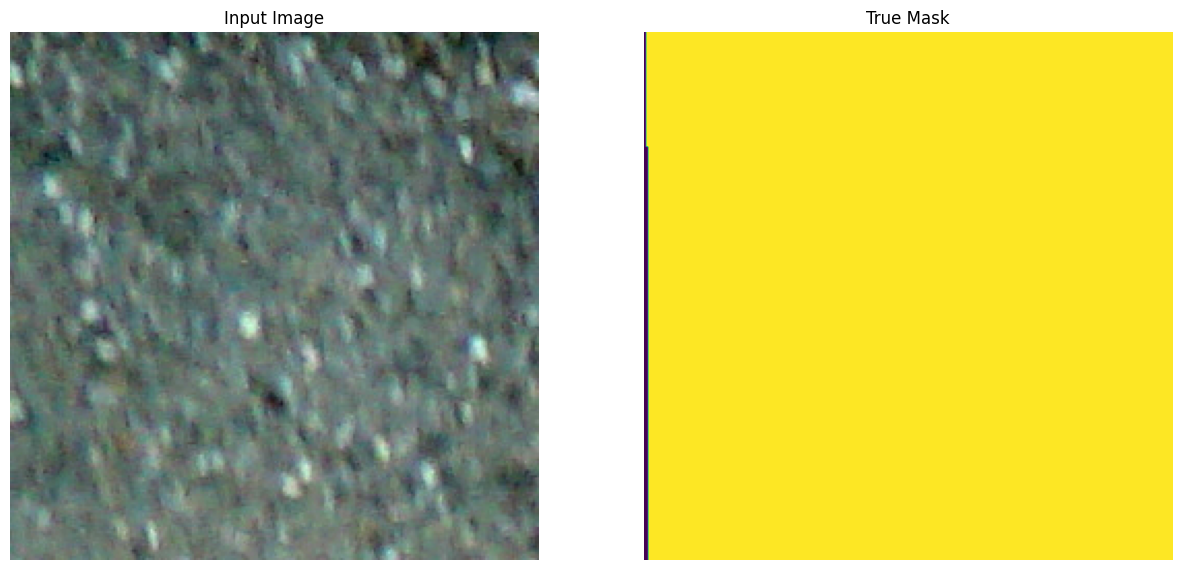

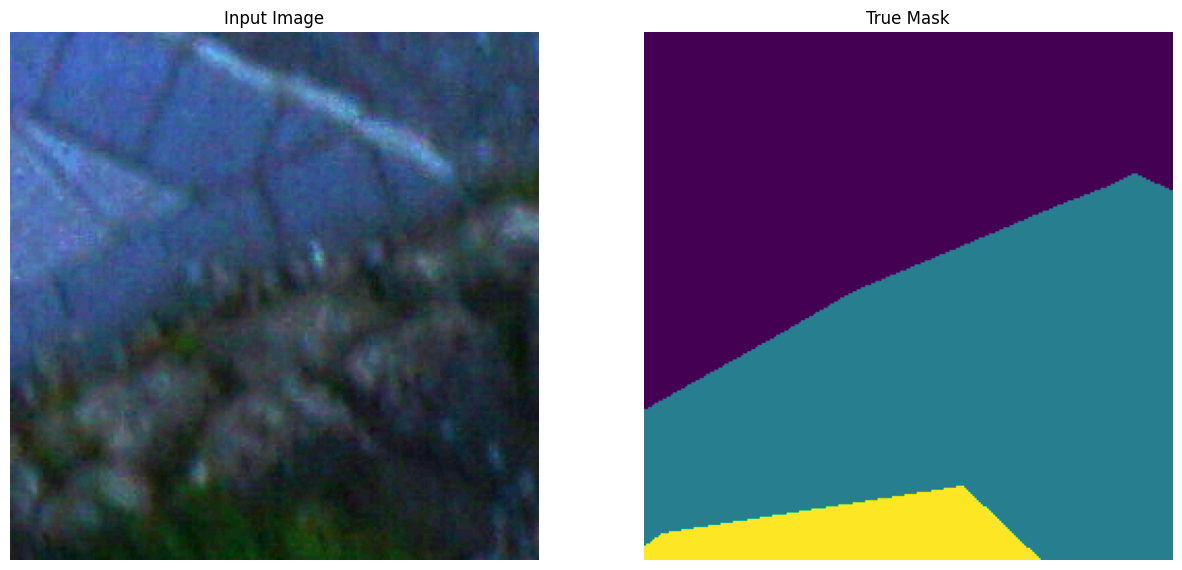

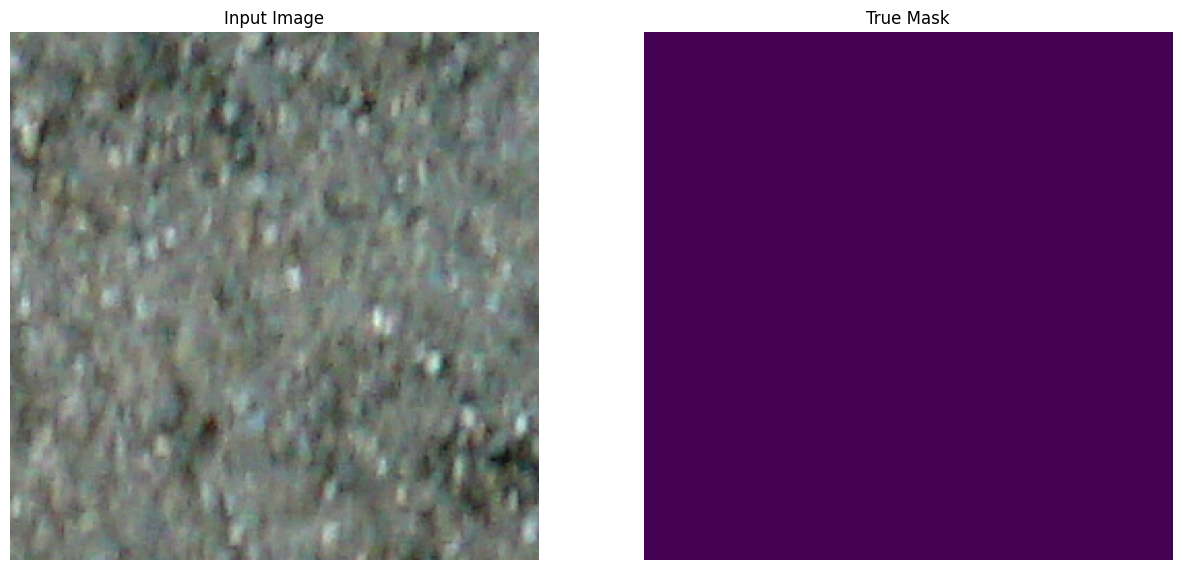

In [ ]:
for images, masks in train_batches.take(3):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

This cell initializes and compiles the segmentation model based on the improved U-Net architecture using **ResNet50** as the encoder. The steps include:

- **Model Instantiation**:
  - `OUTPUT_CLASSES = 25`: Specifies the number of segmentation classes.
  - `improved_unet`: Calls the custom function to create the improved U-Net model with:
    - `input_shape=(256, 256, 3)`: The dimensions of input images.
    - `num_classes=OUTPUT_CLASSES`: The number of output classes in the segmentation task.

- **Model Compilation**:
  - **Optimizer**:
    - Uses `tf.keras.optimizers.Adam()`, an adaptive optimizer known for its efficiency in deep learning tasks.
  - **Loss Function**:
    - `tf.keras.losses.SparseCategoricalCrossentropy`: Computes the loss for multi-class segmentation tasks.
    - `from_logits=False`: Indicates the model outputs probabilities (softmax activation applied).
  - **Metrics**:
    - `accuracy`: Tracks the overall classification accuracy during training.
    - `SparseCategoricalAccuracy`: Monitors the pixel-level accuracy for multi-class segmentation tasks.

This cell sets up the **ResNet50-based U-Net model** for training, ensuring that it uses an effective optimizer, a suitable loss function, and meaningful metrics for evaluating performance.


In [ ]:
# Instantiate the model
OUTPUT_CLASSES = 25
model = improved_unet(input_shape=(256, 256, 3), num_classes=OUTPUT_CLASSES)

# Compile the model with appropriate optimizer, loss function, and metrics
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics. SparseCategoricalAccuracy()]
)

This cell trains the improved U-Net model using the prepared datasets and evaluates its performance on the validation set. The steps include:

- **Training Configuration**:
  - The training process is set to run for 30 epochs.
  - The datasets used are:
    - `train_batches`: Training dataset with augmentation and batching.
    - `val_batches`: Validation dataset with batching only.

- **Callbacks**:
  - Includes a custom callback (`DisplayCallback`) that visualizes predictions on sample images at the end of each epoch.

- **Metrics**:
  - Tracks training and validation loss, accuracy, and sparse categorical accuracy during the training process.

- **Sample Output**:
  - After 30 epochs, the model achieved the following:
    - Training loss: 1.4555
    - Training accuracy: 60.38%
    - Validation loss: 4.9086
    - Validation accuracy: 30.60%

This step trains the model to learn optimal weights for segmenting images while monitoring its performance on the validation dataset.


1/1 [==============================] - 0s 146ms/step


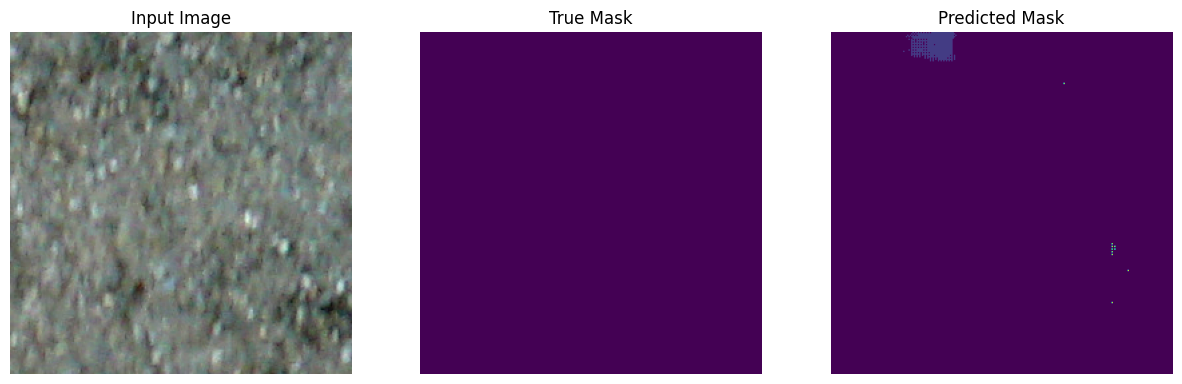


Sample Prediction after epoch 30

4/4 [==============================] - 48s 13s/step - loss: 1.4555 - accuracy: 0.6038 - sparse_categorical_accuracy: 0.6038 - val_loss: 4.9086 - val_accuracy: 0.3060 - val_sparse_categorical_accuracy: 0.3060


In [ ]:
EPOCHS = 30
VALIDATION_STEPS = len(val_image_path) // BATCH_SIZE
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches,
                          callbacks=[DisplayCallback()])

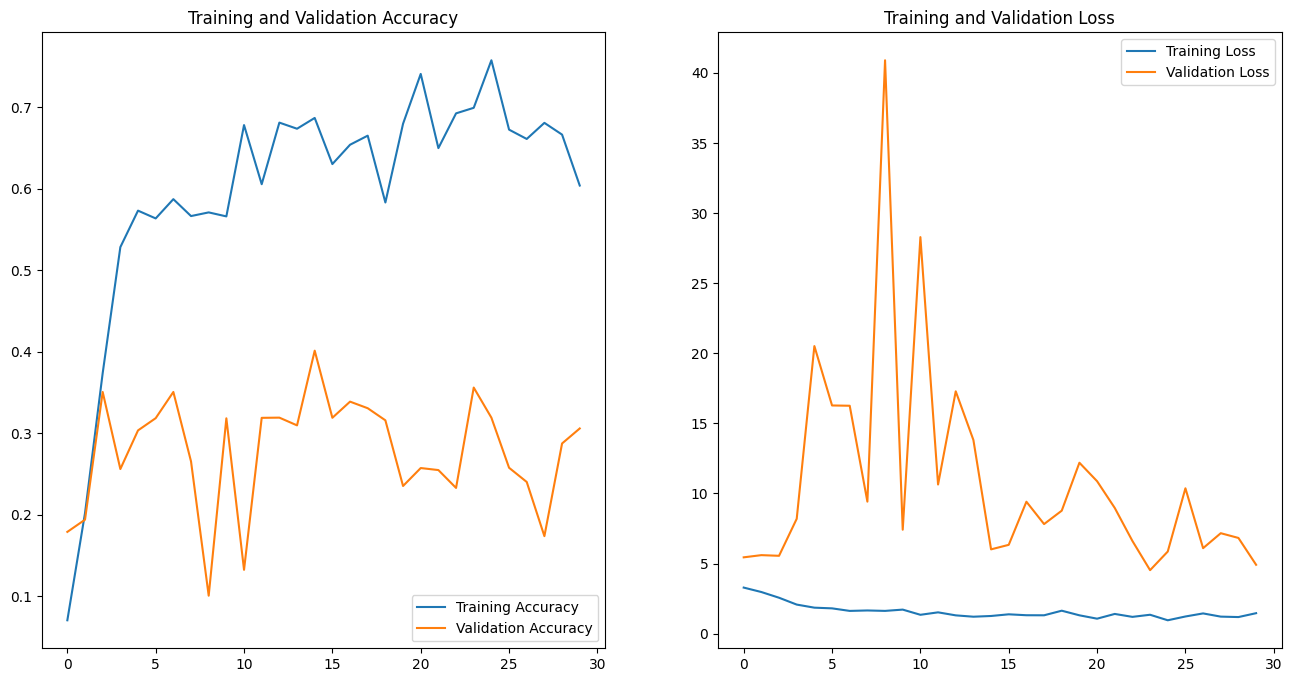

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

This cell implements a dynamic learning rate adjustment strategy and trains the improved U-Net model. The steps include:

- **Learning Rate Scheduler**:
  - `ReduceLROnPlateau`:
    - Monitors the validation loss (`val_loss`).
    - Reduces the learning rate by a factor of 0.5 if the validation loss does not improve for 3 consecutive epochs (`patience=3`).
    - Ensures the minimum learning rate does not go below `1e-6`.
    - Provides verbose feedback during the training process.

- **Model Instantiation**:
  - `improved_unet`: Creates the improved U-Net model with:
    - `input_shape=(256, 256, 3)`: Input image dimensions.
    - `num_classes=OUTPUT_CLASSES`: Specifies the number of segmentation classes.

- **Model Compilation**:
  - **Optimizer**:
    - Uses the Adam optimizer with a reduced learning rate (`learning_rate=1e-4`) for stable training.
  - **Loss Function**:
    - `sparse_categorical_crossentropy`: Suitable for multi-class segmentation tasks.
    - Mentions potential alternatives like Dice loss or focal loss for future experimentation.
  - **Metrics**:
    - Tracks `accuracy` and `SparseCategoricalAccuracy` during training and validation.

- **Model Training**:
  - Calls the `fit` method to train the model:
    - `train_batches`: Training dataset.
    - `val_batches`: Validation dataset.
    - `EPOCHS`: Number of training epochs.
    - `STEPS_PER_EPOCH`: Number of steps in each training epoch.
    - `VALIDATION_STEPS`: Number of validation steps per epoch.
    - **Callbacks**:
      - `DisplayCallback`: Provides visual feedback of predictions during training.
      - `lr_scheduler`: Dynamically adjusts the learning rate based on validation loss.

This cell ensures efficient training with dynamic learning rate adjustments and real-time monitoring of model performance.


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Instantiate the model
OUTPUT_CLASSES = 25
model = improved_unet(input_shape=(256, 256, 3), num_classes=OUTPUT_CLASSES)

# Compile the model with a lower learning rate and additional regularization
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',  # Consider trying Dice or focal loss as alternatives
    metrics=['accuracy', tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Train the model with the learning rate scheduler
model_history = model.fit(
    train_batches,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_steps=VALIDATION_STEPS,
    validation_data=val_batches,
    callbacks=[DisplayCallback(), lr_scheduler]  # Include lr_scheduler for dynamic learning rate adjustments
)

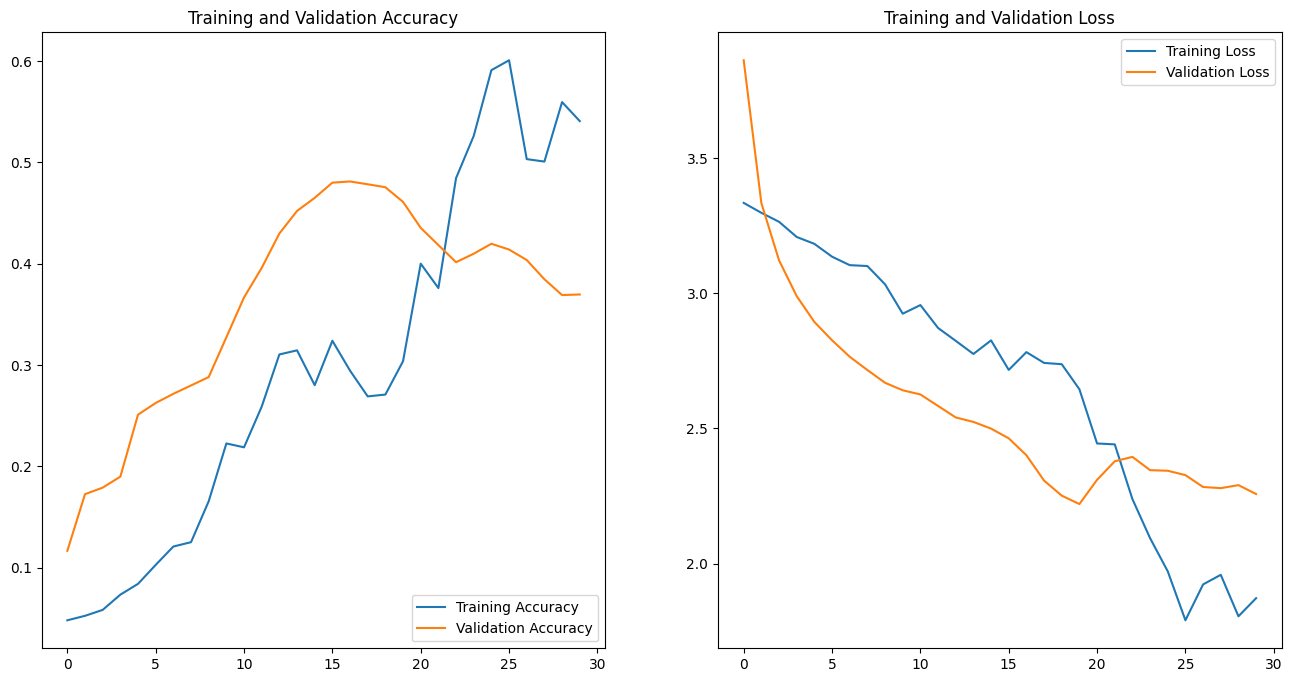

In [ ]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()